In [2]:
# candle sticks image processing
# simple example from the researchers code https://github.com/pecu/Series2GAF/blob/master/cnn_example/README.md
# GOAL# firstly image process the candle stick chart, high open low close needed I guess?
# How will you classify the shapes? need to measure slope etc and assign a value?
# Get CNN workgin with some level of input data
# How do we then process the pickle file to train a GAN? create the full cycle and then worry about input data and if that is correct.
# then select the model features, and pattern match the shit out of it.
import numpy as np
from series2gaf import *
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
EURUSD = pd.DataFrame(pd.read_csv(r"C:\Users\edgil\Documents\SysTrade\candlesticks\EURUSDOHLC.csv"))
EURUSD['Datetime'] = pd.to_datetime(EURUSD['Datetime'], format="%d/%m/%Y %H:%M")

regressiondata = EURUSD[84800:86000]
testdata = EURUSD[85000:86000]

In [4]:
# add a Rolling regression slope term to fx data
import matplotlib.dates as mpl_dates
import statsmodels.api as sm
model = LinearRegression()
def RegressionCoeff(dependent):
    #yx = pd.concat([pd.DataFrame(depedent[0]),pd.DataFrame(depedent[1])], axis = 1).dropna()
    #yx.columns = ["y", "x"]
    dependent =  pd.DataFrame(dependent)
    # single variable only for reshape of -1,1
    ols = model.fit(np.array(dependent.iloc[:,1]).reshape(-1,1), np.array(dependent.iloc[:,0]))
    #ols = model.fit(np.array(yx["x"]).reshape(-1,1), np.array(yx["y"]))
    return(ols.coef_)

#print(ols.coef_)
    
#testdata.columns
testdata['TimeNumbers'] = testdata['Datetime'].apply(mpl_dates.date2num)
y = testdata["Close"].tail(20)
x = testdata["TimeNumbers"].tail(20)
# axis = 1 merge on col
yx = pd.concat([y,x], axis = 1).dropna()
yx.columns = ["y", "x"]
dependent = np.array(yx["y"])
# need to use reshape here as the explanatory variables need to be in form [[sample pred], [another iteration/row], [3rd row]] etc
explanatory = np.array(yx["x"]).reshape(-1,1)
ols = model.fit(explanatory, dependent)
predictors =  sm.add_constant(explanatory)
mod = sm.OLS(dependent, predictors)
res = mod.fit()
print(res.summary())
#print(100*ols.coef_)

def testfn(dependent):
        dependent =  pd.DataFrame(dependent)
        return(dependent.iloc[1,0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     3.841
Date:                Sun, 28 Mar 2021   Prob (F-statistic):             0.0657
Time:                        19:52:45   Log-Likelihood:                 100.27
No. Observations:                  20   AIC:                            -196.5
Df Residuals:                      18   BIC:                            -194.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -725.2443    370.679     -1.957      0.0

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


        Intercept  TimeNumbers
85990 -154.254883     0.000211
85991 -239.481323     0.000327
85992 -313.180054     0.000427
85993 -413.447266     0.000563
85994 -497.952393     0.000677
85995 -575.486145     0.000783
85996 -667.518433     0.000908
85997 -762.509949     0.001036
85998 -842.803528     0.001145
85999 -909.720947     0.001236


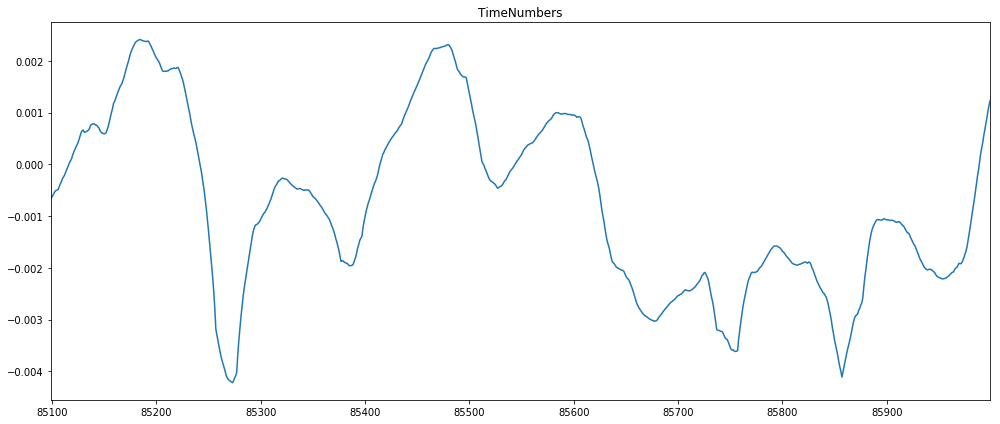

In [12]:
import matplotlib.dates as mpl_dates
from statsmodels.regression.rolling import RollingOLS
#testdata["Slope"] = testdata[["Close", "Datetime"]].rolling(20).apply(RegressionCoeff)
#testdata["Slope"] = testdata[["Close", "Datetime"]].rolling(20).apply(lambda x: RegressionCoeff(x['Close'], x['Datetime']))
testdata['TimeNumbers'] = testdata['Datetime'].apply(mpl_dates.date2num)
#testdata.iloc[:5, 1]
#print(testdata[["Close", "TimeNumbers"]].rolling(20).apply(testfn))
# same window as the gan window
window_size = 100
model = RollingOLS.from_formula("Close ~ TimeNumbers", data = testdata, window= window_size)
results = model.fit(params_only=True)
print(results.params.tail(10))
# Geeting the correct slope now, so can start classifying the trend now.
fig = results.plot_recursive_coefficient(variables=['TimeNumbers'], figsize=(14,6))
#print(testdata[['TimeNumbers']].tail())

In [25]:
# we have coeffs now to classify the trend.
testdata["TrendCoeffs"] = results.params["TimeNumbers"]
#print(results.params["TimeNumbers"].tail(10))
# the trend is based on thr rolling average of the sign of coeffs
# matched to the window_size of the gram field
testdata["TrendDir"] = np.sign(testdata["TrendCoeffs"].rolling(window_size).mean())
testdata = testdata.dropna()

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
print(testdata.head(10))

                 Datetime      Open      High       Low     Close  \
85198 2018-03-27 13:00:00  1.238675  1.239905  1.237750  1.239100   
85199 2018-03-27 14:00:00  1.239105  1.240950  1.238955  1.239365   
85200 2018-03-27 15:00:00  1.239350  1.241335  1.238930  1.240870   
85201 2018-03-27 16:00:00  1.240855  1.241615  1.240640  1.241380   
85202 2018-03-27 17:00:00  1.241375  1.241495  1.240395  1.240925   
85203 2018-03-27 18:00:00  1.240945  1.241195  1.240000  1.240060   
85204 2018-03-27 19:00:00  1.240070  1.240600  1.239455  1.239655   
85205 2018-03-27 20:00:00  1.239650  1.240525  1.239600  1.240275   
85206 2018-03-27 21:00:00  1.240275  1.240805  1.240090  1.240575   
85207 2018-03-27 22:00:00  1.240605  1.240910  1.240180  1.240615   

         TimeNumbers  TrendCoeffs  TrendDir  
85198  736780.541667     0.002137       1.0  
85199  736780.583333     0.002094       1.0  
85200  736780.625000     0.002056       1.0  
85201  736780.666667     0.002027       1.0  
85202  736

In [27]:
# workings
testy = testdata[["Open","High", "Low","Close"]].values
#flat_list = [item for sublist in testy for item in sublist]

from series2gaf import *
#random_series = np.random.uniform(low=50.0, high=150.0, size=(200,))

#timeSeries = list(random_series)
window_size = window_size #5
rolling_length = 50 #2
fileName = 'demo_%02d_%02d' % (window_size, rolling_length)
# gan_rand is made  up of 10 elements (lists, which are image windows), within that is a further 50 elements (np.array) and in each of those arrays we have a further 50 numbers (whihc are the params for each image window).
# when using win = 5 and rolling = 2, then gan rand was 95 elements, with 5 further elements (np.array) and then another 5 inside.
# th enormalise window scaling of 2 doubles up the window length.
# now we get a file named demo_50_10_gaf.pkl in current directory. inside the pickle file, you got a grammian angular field with shape (15, 50, 50).

# shape[0] refers to data amount : floor((len(timeSeries)-(normalize_window_scaling-1)*windowSize)/windowSize)
# shape[1] refers to image width : sliding windowSize of the picture to make into a GAF
# shape[2] refers to image height : wthe number of steps to move forward before running another GAF, i.e. overlapping?
gan_rand = GenerateGAF(all_ts=testy,
            window_size=window_size,
            rolling_length=rolling_length,
            fname=fileName,
            normalize_window_scaling=1.0)

ts_img = np.load('%s_gaf.pkl' % fileName, allow_pickle= True)
PlotHeatmap(ts_img)

Generating...:   0%|          | 0/14 [00:00<?, ?it/s]

Generating...: 100%|##########| 14/14 [00:00<00:00, 260.33it/s]

Output Heatmaps...:   0%|          | 0/14 [00:00<?, ?it/s]

Output Heatmaps...:   7%|7         | 1/14 [00:00<00:03,  4.21it/s]

Output Heatmaps...:  14%|#4        | 2/14 [00:00<00:02,  4.58it/s]

Output Heatmaps...:  21%|##1       | 3/14 [00:00<00:02,  4.92it/s]

Output Heatmaps...:  29%|##8       | 4/14 [00:00<00:01,  5.15it/s]

Output Heatmaps...:  36%|###5      | 5/14 [00:00<00:01,  5.28it/s]

Output Heatmaps...:  43%|####2     | 6/14 [00:01<00:01,  5.22it/s]

Output Heatmaps...:  50%|#####     | 7/14 [00:01<00:01,  5.10it/s]

Output Heatmaps...:  57%|#####7    | 8/14 [00:01<00:01,  5.22it/s]

Output Heatmaps...:  64%|######4   | 9/14 [00:01<00:00,  5.48it/s]

Output Heatmaps...:  71%|#######1  | 10/14 [00:01<00:00,  5.66it/s]

Output Heatmaps...:  79%|#######8  | 11/14 [00:02<00:00,  5.71it/s]

Output Heatmaps...:  86%|########5 | 12/14 [00:02<00:00,  5.79it/s]

Output Heatmaps...:  93%|#########2| 13/14 [00:02<00:00,  5.84it/s]

Output Heatmaps...: 100%|##########| 14/14 [00:02<00:00,  5.73it/s]

Output Heatmaps...: 100%|##########| 14/14 [00:02<00:00,  5.54it/s]

In [37]:
# create the labels for the example
n_rolling_data = int(np.floor((len(testdata) - window_size)/rolling_length))
examples = [item for item in range(window_size, len(testdata), rolling_length)]
# get the index values
trend_labels = testdata['TrendDir'].iloc[examples[:n_rolling_data]]
print(examples[:n_rolling_data])
print(trend_labels.values)

[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]
[-1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.]


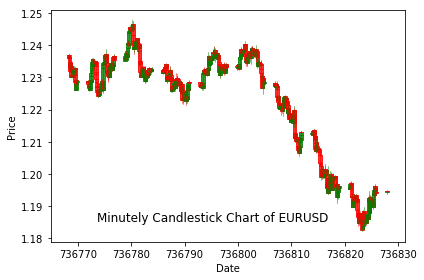

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from matplotlib.finance import candlestick_ohlc
testdata = EURUSD[85000:86000]
ohlc = testdata[["Datetime","Open","High", "Low","Close"]]
# apply datetime to all py_ timestamp objects (pd.to_datetime makes a timestamp object
#ohlc["TrueDt"] = ohlc["Datetime"].map(lambda ts: ts.to_pydatetime())
#ohlc["Datetime"] = ohlc["Datetime"].dt.to_pydatetime()
ohlc['Datetime'] = ohlc['Datetime'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

#candlestick_ohlc(ax, opens = ohlc["Open"].values,highs = ohlc["High"].values, lows = ohlc["Low"].values,closes = ohlc["Close"].values, width=0.6, colorup='green', colordown='red', alpha=0.8)
candlestick_ohlc(ax,ohlc.values , width=0.7, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Minutely Candlestick Chart of EURUSD', y = 0.25)

# Formatting Date
#date_format = mpl_dates.DateFormatter('%d-%m-%Y %')
#ax.xaxis.set_major_formatter(date_format)
#fig.autofmt_xdate()

fig.tight_layout()

plt.show()

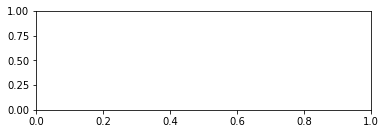

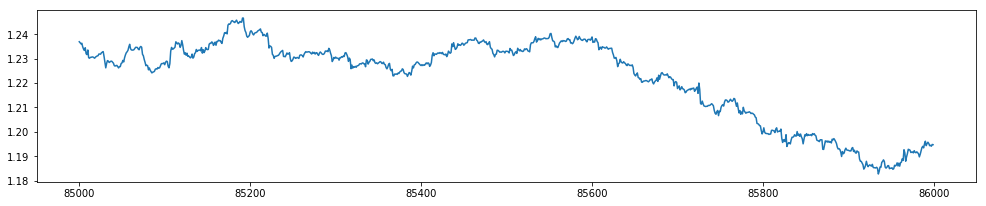

In [38]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
results.plot_recursive_coefficient(variables=['TimeNumbers'], figsize=(14,6))
plt.subplot(2, 1, 2)
plt.plot(testdata["Close"])

In [3]:
# XXX: next steps
# train the cnn to input the image vectors and the classification of that image. (how do I know what the image classfication should be?
# to start set up a dummy classification so that the pipeline of the CNN actually works to completion.
# load the images from pickle, create the layerd CNN to accept those coefficients



,Datetime,Open,High,Low,Close
90227,2019-01-18 19:00:00,1.13657,1.137205,1.136340,1.137020
90228,2019-01-18 20:00:00,1.13702,1.137020,1.136215,1.136540
90229,2019-01-18 21:00:00,1.13653,1.136760,1.136085,1.136275
90230,2019-01-20 22:00:00,1.13615,1.136915,1.135985,1.136650
90231,2019-01-20 23:00:00,1.13664,1.136855,1.136440,1.136555
